In [2]:
# This is a functino that generate the ground truth of lifetime and intensity image, 
# Output in the format of intensity_image_array, lifetime_image_array
from pydoc import plain
from emnist import extract_training_samples
import numpy as np
import tensorflow as tf
from utilities import draw
from scipy.ndimage import gaussian_filter
import h5py
import matplotlib.pyplot as plt

In [5]:
## Create shuffled, resized to 128*128, binarised EMNIST letters/digits

# Combine letters and digits and shuffle the order
digits, _ = extract_training_samples('digits')
letters, _ = extract_training_samples('letters')
characters =np.concatenate((digits, letters))

np.random.shuffle(characters)
# characters = characters[:100000]

# Pad from 28*28 to 32*32
padded_characters = np.zeros((characters.shape[0],32,32))
padded_characters[:,2:-2,2:-2] = characters
characters = padded_characters

## Resize and Binarise
# Run in batches of 50000 to avoid GPU memory OOM
batch = 500
imax = (characters.shape[0] // batch) -1
# Reserve memory on ram to avoid GPU memory OOM
characters_ram = np.zeros([(imax+1)*batch, 128, 128, 1])

# Add colour dimension because tf resize accepts dim (batch, x, y, colour_channel)
characters = np.expand_dims(characters,axis=3)     

# Batch resizing and binarising characters
for i in range(imax):
    # Resize to 128*128
    characters_ram[i*50000:(i+1)*50000,:,:,:] = tf.image.resize(characters[i*50000:(i+1)*50000,:,:,:],(128,128))  # resize all to 128,128
    # Binarise all
    characters_ram[i*50000:(i+1)*50000,:,:,:] = tf.where(characters_ram[i*50000:(i+1)*50000,:,:,:] > 0.5*np.max(characters), 1, 0)

characters = characters_ram
# Squeeze dimension back to (batch, x, y)
characters = np.squeeze(characters, axis=3)        

MemoryError: Unable to allocate 44.5 GiB for an array with shape (364500, 128, 128, 1) and data type float64

In [7]:
## Generate combined and resized images
def ground_truth():

    row = np.random.randint(low = 1, high = 4)
    column = np.random.randint(low = 1, high = 4)
    number_of_characters = row*column
    # randomly pick images from characters
    irand = np.random.randint(low = 0, high = characters.shape[0], size = number_of_characters)
    select_images = np.concatenate(np.expand_dims([characters[i] for i in irand], axis = 0 ))   # Shape (number_of_characters, x, y)

    # Randomly flip rows
    for i, image in enumerate(select_images):
        if np.random.choice([True, False]):
            select_images[i] = np.flip(image, axis = 0)
    # Randomly flip columns
    for i, image in enumerate(select_images):
        if np.random.choice([True, False]):
            select_images[i] = np.flip(image, axis = 1)
    # Randomly rotate clockwise
    for i, image in enumerate(select_images):
        if np.random.choice([True, False]):
            select_images[i] = np.rot90(image, k = 1)
    # Randomly rotate anti-clockwise
    for i, image in enumerate(select_images):
        if np.random.choice([True, False]):
            select_images[i] = np.rot90(image, k = -1)
    
    # Generate individual intensity images
    intensity_images = select_images * np.random.uniform(low = 200, high = 800, size = (select_images.shape[0],1,1))
    for i, image in enumerate(intensity_images):
	    intensity_images[i,:,:] = gaussian_filter(image, 0.1)
    
    # Generate individual lifetime images
    lifetime = np.random.uniform(low = 0.3, high = 1.2, size = (intensity_images.shape[0],1,1))									# unit in ns
    lifetime_images = np.where(intensity_images != 0, 1, 0) * lifetime

    # Stacking 'em all
    iposition = np.reshape(np.random.permutation(np.array(range(number_of_characters))), (row, column))                         # position of each image
    intensity_ground_truth = np.vstack([np.hstack([intensity_images[j] for j in i]) for i in iposition])
    lifetime_ground_truth = np.vstack([np.hstack([lifetime_images[j] for j in i]) for i in iposition])

    # Scale intensity to 128*128
    intensity_ground_truth = tf.image.resize(np.expand_dims(intensity_ground_truth, axis = 2), [128, 128], method='bilinear').numpy()
    intensity_ground_truth = intensity_ground_truth.squeeze()
    # Scale lifetime to 128*128
    lifetime_ground_truth = tf.image.resize(np.expand_dims(lifetime_ground_truth, axis = 2), [128, 128], method='nearest').numpy()
    lifetime_ground_truth = lifetime_ground_truth.squeeze()

    return intensity_ground_truth, lifetime_ground_truth

In [ ]:
# Generate 8000 ground truth
size_sample = 8000
gt_intensity = np.zeros((size_sample, 128, 128))        # batch of ground truth intensity
gt_lifetime = np.zeros((size_sample, 128, 128))         # batch of ground truth lifetime
for i in range(size_sample):
    gt_intensity[i,:,:], gt_lifetime[i,:,:] = ground_truth()

# Write ground truth into file
with h5py.File('Data/ground_truth.h5','w') as f:
    f.create_dataset('intensity_ground_truth', data=gt_intensity)
    f.create_dataset('lifetime_ground_truth', data=gt_lifetime)
# draw(characters[:4])

In [15]:
# Example of a ground truth image
with h5py.File('Data/ground_truth.h5','r')as f:
    intensity_sample = np.array(f['intensity_ground_truth'][0])
    lifetime_sample = np.array(f['lifetime_ground_truth'][0])

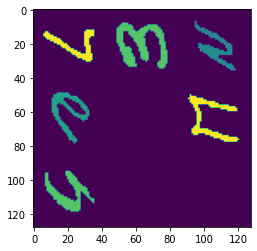

In [16]:
plt.imshow(intensity_sample)

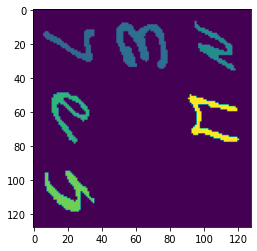

In [17]:
plt.imshow(lifetime_sample)